In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install geopandas

In [1]:
import os
import glob

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import Point

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import pyarrow.feather as feather

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:


def make_pentad(x, y):
    # Determine the separator based on the signs of x and y
    separator = "_" if x < 0 and y >= 0 \
      else "a" if x < 0 and y < 0 \
      else "b" if x >= 0 and y < 0 \
      else "c"

    x = abs(x)
    y = abs(y)
    # get the first digit (the tens) of the minutes
    x1 = int(6 * (x - int(x)))
    y1 = int(6 * (y - int(y)))

    # Get the second digit (the units) of the minutes
    x2 = int(60 * (x - int(x))) % (x1 * 10) if x1 != 0 else int(60 * (x - int(x)))
    y2 = int(60 * (y - int(y))) % (y1 * 10) if y1 != 0 else int(60 * (y - int(y)))

    # round the units into their 5min pentad
    x2 = 0 if x2 < 5 else 5
    y2 = 0 if y2 < 5 else 5

    xx = f"{int(x)}{x1}{x2}"
    yy = f"{int(y)}{y1}{y2}"

    return f"{xx}{separator}{yy}"


def parse_pentad(pentad_str):
    # Determine the separator based on the pentad string
    if "_" in pentad_str:
        separator = "_"
        x_sign = -1
        y_sign = 1
    elif "a" in pentad_str:
        separator = "a"
        x_sign = -1
        y_sign = -1
    elif "b" in pentad_str:
        separator = "b"
        x_sign = 1
        y_sign = -1
    else:
        separator = "c"
        x_sign = 1
        y_sign = 1

    # Extract the latitude and longitude components from the pentad string
    xx, yy = pentad_str.split(separator)
    x_degrees = int(xx[0:-2])
    x_minutes = int(xx[-2:])

    x = x_sign * (x_degrees + x_minutes / 60)

    y_degrees = int(yy[0:-2])
    y_minutes = int(yy[-2:])
    y = y_sign * (y_degrees + y_minutes / 60)

    return x, y


def add_pentad_from_lat_long(
    df: pd.core.frame.DataFrame,
    lat_column_name: str = 'latitude',
    lng_column_name: str = 'longitude',
    pentad_column_name: str = 'pentad'
) -> pd.core.frame.DataFrame:
  """
  Add a pentad column to the dataframe based on the latitude and longitude
  """

  # Create the pentad column based on latitude and longitude values
  df[pentad_column_name] = df.apply(
      lambda row: make_pentad(row[lat_column_name], row[lng_column_name]),
      axis=1
  )

  return df


def add_lat_long_from_pentad(
    df: pd.core.frame.DataFrame,
    lat_column_name: str = 'latitude',
    lng_column_name: str = 'longitude',
    pentad_column_name: str = 'pentad'
) -> pd.core.frame.DataFrame:
  """
  Add a latitude and longitude column to the dataframe based on the pentad
  """
  lat_long_df = df[pentad_column_name].apply(
      lambda x: pd.Series(parse_pentad(x), index=[lat_column_name, lng_column_name])
  )

  # Add latitude and longitude columns to the input DataFrame
  df[lat_column_name] = lat_long_df[lat_column_name]
  df[lng_column_name] = lat_long_df[lng_column_name]

  return df


def scale_covariates(covariates_df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
  scaler = StandardScaler()
  X = covariates_df.drop('pentad', axis=1)
  X_scaled = scaler.fit_transform(X)

  df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

  # Add the 'pentad' column back to the scaled DataFrame
  return pd.concat([covariates_df['pentad'], df_scaled], axis=1)


def load_covariates(config: dict, force_reload=False) -> pd.core.frame.DataFrame:
  """
  This is the main
  """
  # first check if the processed version of the file exists
  bioclim_combined_path = config['root_data_dir'] + config['bioclim_combined']
  feather_path = bioclim_combined_path + '.feather'

  if os.path.exists(feather_path) and not force_reload:
    print("Using cached bioclim file...")
    return feather.read_feather(feather_path)
  else:
    # load and flatten all of the bioclim files
    df_covariates = process_raw_covariates(config)
    # load the covariates exported from Google EE
    df_google_ee_covariates = load_google_ee_covariates(config, force_reload)

    df_final = pd.merge(df_covariates, df_google_ee_covariates, on='pentad', how='left')

    # Fill in any missing values with NaN
    df_final.fillna(value=np.nan, inplace=True)

    # Scale the values
    df_scaled = scale_covariates(df_final)

    # Make sure the letters in the pentad column are all lowercase
    df_scaled['pentad'] = df_scaled['pentad'].str.lower()

    # Some pentads have no observations so the species and counts columns are set to 0
    df_scaled.fillna(df_scaled.mean(), inplace=True)

    # Add a latitude and longitude from the pentads
    df_scaled = add_lat_long_from_pentad(df_scaled)

    # We will read from this file next time
    feather.write_feather(df_scaled, feather_path)

    # Save it back to google drive for next time
    df_scaled.to_csv(bioclim_combined_path, index=False)

    return df_scaled


def process_raw_covariates(config: dict) -> pd.core.frame.DataFrame:
    dir_path = config['root_data_dir'] + config['bioclim_dir']

    # Use glob to select only the CSV files in the directory
    csv_files = glob.glob(dir_path + '*.csv')

    # Initialize an empty list to hold the DataFrames
    dfs = []

    # Iterate over all the CSV files and add them to the list
    for file in csv_files:
        print(f"Processing file {file}...")
        # Read the CSV file into a DataFrame with the 'Name' column as the index
        df = pd.read_csv(file, usecols=['Name', 'MEAN'], dtype=str)
        # Remove the '.csv' suffix from the filename
        col_name = file.split('/')[-1].rstrip('.csv').lower()
        # Rename the 'MEAN' column with the filename
        df.rename(columns={'MEAN': col_name, 'Name': 'pentad'}, inplace=True)
        # Add the DataFrame to the list
        dfs.append(df.set_index('pentad'))

    # Concatenate all the DataFrames along the columns axis (axis=1)
    df_final = pd.concat(dfs, axis=1, sort=False, join='outer')
    # Convert the pentad column into a regular column again
    df_final.reset_index(inplace=True)

    print(f"Flattened .csv files into the following dimensions: {df_final.shape}")

    return df_final

def load_google_ee_covariates(
    config: dict,
    force_reload=False
) -> pd.core.frame.DataFrame:
  google_ee_path = config['root_data_dir'] + config['google_ee_dir']
  feather_path = google_ee_path + config['google_ee_combined']

  if os.path.exists(feather_path) and not force_reload:
    print("Using google ee covariates file...")
    return feather.read_feather(feather_path)

  # Get a list of all CSV files in the folder
  csv_files = glob.glob(os.path.join(google_ee_path, '*.csv'))

  # Initialize an empty DataFrame
  merged_df = None

  # Iterate over the CSV files
  for file in csv_files:
      print("Processing Google EE file: ", file)
      # Read each CSV file into a DataFrame
      df = pd.read_csv(file)

      # Check if merged_df is empty (first iteration)
      if merged_df is None:
          # Set merged_df to the current DataFrame
          merged_df = df
      else:
          # Merge the current DataFrame with the existing merged_df based on the 'pentad' column
          merged_df = merged_df.merge(df, on='pentad', how='outer')

  # We will read from this file next time
  feather.write_feather(merged_df, feather_path)

  return merged_df

def load_ebird_observations(
    config: dict,
    force_reload=False
) -> pd.core.frame.DataFrame:
  ebird_path = config['root_data_dir'] + config['ebirds']
  feather_path = ebird_path + '.feather'

  if os.path.exists(feather_path) and not force_reload:
    print("Using ebird observations file...")
    return feather.read_feather(feather_path)

  chunksize = 1e6  # Adjust this value based on your available memory

  # Initialize an empty DataFrame to store the final result
  final_observations = pd.DataFrame(columns=['species', 'pentad'])
  chunk_count = 1
  # Read and process the CSV file in chunks
  for chunk in pd.read_csv(ebird_path, sep='\t', chunksize=chunksize):
      print(f"Loaded chunk: {chunk_count}")
      chunk_count = chunk_count + 1

      add_pentad_from_lat_long(
          chunk,
          lat_column_name='decimalLatitude',
          lng_column_name='decimalLongitude'
      )

      # Concatenate the chunk's processed data to the final DataFrame
      final_observations = pd.concat([final_observations, chunk[['species', 'pentad']]])


  # Save the final DataFrame to a feather file
  feather.write_feather(final_observations, feather_path)

  # Return the final DataFrame
  return final_observations


def load_inat_observations(config: dict, force_reload=False) -> pd.core.frame.DataFrame:
  inat_path = config['root_data_dir'] + config['inat_observations']
  feather_path = inat_path + '.feather'

  if os.path.exists(feather_path) and not force_reload:
    print("Using inat observations file...")
    return feather.read_feather(feather_path)

  observations = pd.read_csv(inat_path, sep='\t')
  observations = add_pentad_from_lat_long(
      observations,
      lat_column_name='decimalLatitude',
      lng_column_name='decimalLongitude'
  )

  df = observations[['species', 'pentad']]

  # We will read from this file next time
  feather.write_feather(df, feather_path)

  return df


def load_abap_observations(config: dict, species_file: str, force_reload=False) -> pd.core.frame.DataFrame:
  """
  Fetch the ABAP data for a given species. The following columns are included:
  - pentad: The pentad that the observations occurred in
  - total_spp: The total number of all species that were seen in the pentad
  - observed: 1 if the target species was seen in this card or not
  """
  abap_path = config['root_data_dir'] + config['abap_observations_dir'] + species_file

  feather_path = abap_path + '.feather'

  if os.path.exists(feather_path) and not force_reload:
    print("Using abap observations file...")
    return feather.read_feather(feather_path)

  observations = pd.read_csv(abap_path)
  observations.rename(columns = {'Pentad':'pentad', 'TotalSpp': 'total_spp'}, inplace = True)
  observations['observed'] = observations['Taxonomic_name'].apply(lambda x: 0 if x == '-' else 1)
  observations['pentad'] = observations['pentad'].str.lower()
  df = observations[['pentad', 'total_spp', 'observed']]

  print("Total target species in ABAP: ", len(df[df['observed'] == 1]))

  # We will read from this file next time
  feather.write_feather(df, feather_path)

  return df

def merge_observations(
    inat_df: pd.core.frame.DataFrame,
    abap_df: pd.core.frame.DataFrame,
    ebird_df: pd.core.frame.DataFrame,
    species_name: str
) -> pd.core.frame.DataFrame:
  """
  inat: {'pentad', 'species'}
  abap: {'pentad', 'total_spp', 'observed'}
  inat: {'pentad', 'species'}

  return merged: {'pentad', 'total_observations', 'target_observations'}
  """

  # The total number of observations per pentad for all species
  inat_totals = inat_df.groupby('pentad').size().reset_index(name='total_observations')
  # The total number of observations of the target species per pentad
  inat_species_totals = inat_df[inat_df['species'] == species_name].groupby('pentad').size().reset_index(name='target_observations')
  # Merge the dataframes on the 'pentad' column, keeping all rows from inat_totals
  merged_inat_df = inat_totals.merge(inat_species_totals, on='pentad', how='left')
  # Fill missing values in the 'target_observations' column with 0
  merged_inat_df['target_observations'] = merged_inat_df['target_observations'].fillna(0)

  # The total number of observations per pentad for all species
  ebird_totals = ebird_df.groupby('pentad').size().reset_index(name='total_observations')
  # The total number of observations of the target species per pentad
  ebird_species_totals = ebird_df[ebird_df['species'] == species_name].groupby('pentad').size().reset_index(name='target_observations')
  # Merge the dataframes on the 'pentad' column, keeping all rows from inat_totals
  merged_ebird_df = ebird_totals.merge(ebird_species_totals, on='pentad', how='left')
  # Fill missing values in the 'target_observations' column with 0
  merged_ebird_df['target_observations'] = merged_ebird_df['target_observations'].fillna(0)


  # we concat onto the merged_ebird_df to save memory
  merged_ebird_df = pd.concat([merged_ebird_df, merged_inat_df], ignore_index=True)
  inat_ebird_df = merged_ebird_df.groupby('pentad').agg({'target_observations': 'sum', 'total_observations': 'sum'}).reset_index()
  print("inat_ebird_df: ", inat_ebird_df.shape, inat_ebird_df.columns)

  abap_grouped = abap_df.groupby('pentad')[['total_spp', 'observed']].sum()
  # Merge the dataframes on the 'pentad' column using an outer join to include all unique pentad values
  merged_abap = inat_ebird_df.merge(abap_grouped, on='pentad', how='outer')

  print("Merged_abap: ", merged_abap.shape, merged_abap.columns)
  # Fill missing values with 0
  merged_abap[['total_observations', 'target_observations', 'total_spp', 'observed']] = merged_abap[['total_observations', 'target_observations', 'total_spp', 'observed']].fillna(0)

  # Sum the corresponding columns
  merged_abap['total_observations'] = merged_abap['total_observations'] + merged_abap['total_spp']
  merged_abap['target_observations'] = merged_abap['target_observations'] + merged_abap['observed']

  # Drop the unnecessary columns
  merged_abap = merged_abap.drop(columns=['total_spp', 'observed'])
  print(abap_grouped.shape, merged_inat_df.shape, merged_ebird_df.shape, merged_abap.shape)

  return merged_abap


def add_target(
    observations_df: pd.core.frame.DataFrame,
    total_column: str = 'total_observations',
    target_species_total_column: str = 'target_observations',
    target_column: str = 'target',
    absence_observations = 10
) -> pd.core.frame.DataFrame:
  """
  Calculate pseudo-absence data and target value for model training.

  target =
    1 if target_species_count > 0
    0 if target_species_count == 0 and total_observations > threshold
    -1 otherwise
  """

  # Add the 'target' column to the new dataframe
  observations_df[target_column] = np.where(
      observations_df[target_species_total_column] > 0, 1,
          np.where(
              np.bitwise_and(
                  observations_df[target_species_total_column] == 0,
                  observations_df[total_column] >= absence_observations
              ), 0, -1
          )
      )

  return observations_df


def merge_covariates_observations(
    covariates_df: pd.core.frame.DataFrame,
    observations_df: pd.core.frame.DataFrame
) -> pd.core.frame.DataFrame:
  merged_df = covariates_df.merge(observations_df, on='pentad', how='left')
  # Fill missing values with 0
  merged_df[['total_observations', 'target_observations']] = merged_df[['total_observations', 'target_observations']].fillna(0)

  return merged_df


def load_merged_observations_covariates(
    config:dict, species_name, force_reload=False
):
  merged_observations_covariates_path = (
      config['root_data_dir'] +
      'merged_observations_covariates' +
      species_name.lower().replace(" ", "_") +
      '.csv'
  )

  feather_path = merged_observations_covariates_path + '.feather'

  if os.path.exists(feather_path) and not force_reload:
    print("Using cached merged observation and covariates file...")
    return feather.read_feather(feather_path)

  covariates = load_covariates(config, force_reload=force_reload)
  inat_data = load_inat_observations(config, force_reload=force_reload)
  abap_data = load_abap_observations(config, 'blue_swallow.csv', force_reload=True)
  ebirds_df = load_ebird_observations(config, force_reload=force_reload)

  print("Total iNat records: ", len(inat_data[inat_data['species'] == species_name]))
  print("Total eBirds records: ", len(ebirds_df[ebirds_df['species'] == species_name]))

  merged_observations_df = merge_observations(
    inat_data, abap_data, ebirds_df, species_name
  )

  merged_observations_covariates_df = merge_covariates_observations(covariates, merged_observations_df)

  # We will read from this file next time
  feather.write_feather(merged_observations_covariates_df, feather_path)

  # Save it back to google drive for next time
  merged_observations_covariates_df.to_csv(merged_observations_covariates_path, index=False)

  return merged_observations_covariates_df


In [ ]:
data_config = {
    'root_data_dir': 'drive/MyDrive/BLSA/data/',
    'inat_observations': 'Africa/inat_aves_africa.csv',
    'abap_observations_dir': 'ABAP/',
    'bioclim_dir': 'BioClimPentad/',
    'bioclim_combined': 'Africa/bioclim_africa.feather',
    'google_ee_dir': 'GoogleEE/',
    'google_ee_combined': 'google_ee_combined.feather',
    'ebirds': 'eBirds/eBirds-gbif-africa.csv'
}

# species_name = 'Terpsiphone viridis' # paradise flycatcher
# species_name = 'Sagittarius serpentarius'
species_name = 'Hirundo atrocaerulea' #blue swallow

training_data_df = load_merged_observations_covariates(
    data_config,
    species_name,
    force_reload=False
)

training_data_df = add_target(
    training_data_df,
    absence_observations=500
)

training_data_df.head()

Using cached merged observation and covariates file...


,pentad,africapentabio10,africapentabio1,africapentabio11,africapentabio17,africapentabio15,africapentabio14,africapentabio13,africapentabio19,africapentabio18,...,Landcover_bare-coverfraction,Landcover_shrub-coverfraction,Landcover_tree-coverfraction,Landcover_water-permanent-coverfraction,Landcover_water-seasonal-coverfraction,latitude,longitude,target_observations,total_observations,target
0,0000_0915,-0.183189,0.609605,1.055750,0.165252,-0.134292,-0.134292,2.780916,-0.330174,3.651513,...,-1.930864e-16,-7.876700e-16,2.574486e-16,5.187282e-17,9.807565e-18,-0.0,9.250000,0.0,0.0,-1
1,0000_0920,-0.233984,0.547694,1.014257,0.236263,-0.128580,-0.128580,2.850734,-0.312294,3.729431,...,-7.947814e-01,-8.613967e-01,2.817738e+00,-1.002313e-01,-9.987467e-02,-0.0,9.333333,0.0,0.0,-1
2,0000_0925,-0.189033,0.608621,1.059158,0.268634,-0.082502,-0.082502,2.858661,-0.304143,3.704510,...,-7.966910e-01,-8.666342e-01,2.566506e+00,8.136112e-02,7.430462e-02,-0.0,9.416667,0.0,0.0,-1
3,0000_0930,-0.178942,0.623981,1.061176,0.245641,-0.079846,-0.079846,2.860677,-0.309932,3.649600,...,-7.967843e-01,-8.696494e-01,2.510836e+00,7.487874e-03,6.735794e-02,-0.0,9.500000,0.0,0.0,-1
4,0000_0935,-0.188098,0.614487,1.057040,0.231984,-0.098437,-0.098437,2.873474,-0.313371,3.628221,...,-7.967897e-01,-8.930026e-01,2.520827e+00,1.296743e-01,4.655842e-02,-0.0,9.583333,0.0,0.0,-1


In [ ]:
import geopandas as gpd

# axes[1].set_xlim([15.5, 33.5])
# axes[1].set_ylim([-36, -20.5])

def plot_map(df, column, colors=None, filename=None, alongside=True):
    map = gpd.GeoSeries([Point(v) for v in df[['longitude', 'latitude']].values])

    # Define plot configurations
    plot_config = [
        {"title": "Pentad - Full View", "xlim": None, "ylim": None},
        {"title": "Pentad - Scaled View", "xlim": [26, 38], "ylim": [-33, -5]}
    ]

    # Configure plots
    for i, config in enumerate(plot_config):
        fig, ax = plt.subplots(figsize=(15, 8))

        map.plot(color="lightgrey", ax=ax)

        x = df['longitude']
        y = df['latitude']
        z = df[column]

        if colors is not None:
            ax.scatter(x, y, c=colors, s=2)
        else:
            sc = ax.scatter(x, y, c=z, s=2)
            fig.colorbar(sc, ax=ax, label=column)

        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title(config["title"])

        if config["xlim"]:
            ax.set_xlim(config["xlim"])

        if config["ylim"]:
            ax.set_ylim(config["ylim"])

        # Save and/or display plots
        if filename:
            if alongside and i == 0:
                continue
            else:
                prefix = 'africa_' if i==0 else 'cropped_'
                fig.savefig(f"{prefix}{filename}.png", dpi=500)

        if not alongside:
            plt.show()

    if alongside:
        plt.show()

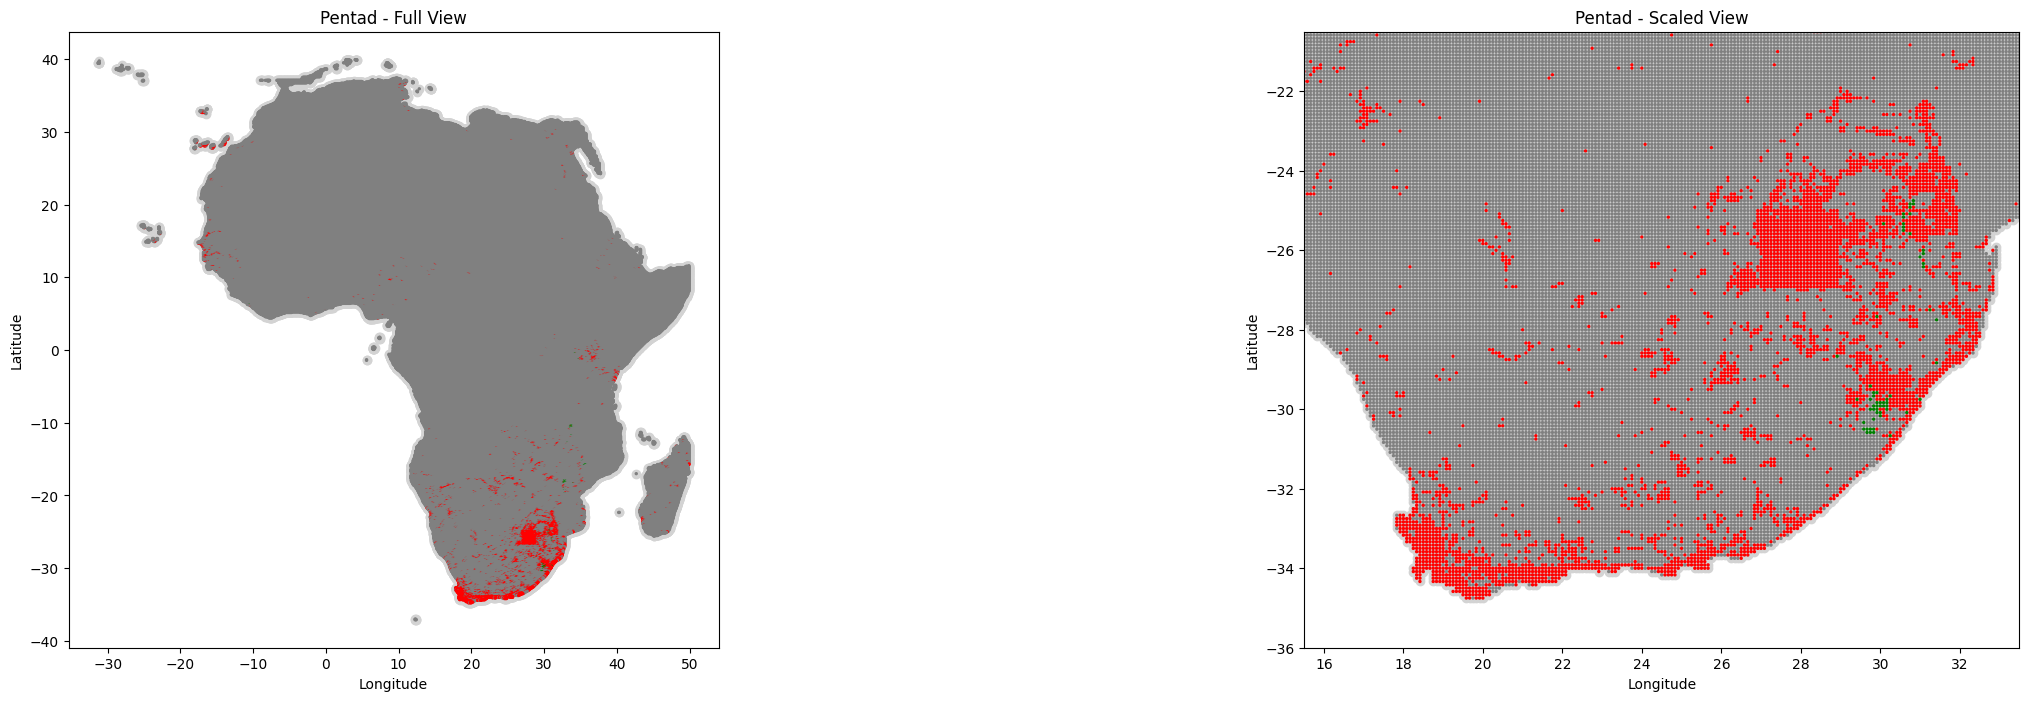

In [ ]:
plot_map(training_data_df, 'target', colors = training_data_df['target'].map({1:'green', -1:'gray', 0:'red'}).values)

In [ ]:

# Get all rows where target = 1
positive_df = training_data_df.query('target == 1')

print("Total observations: ", positive_df.shape[0])
# Get all rows where target = 0
negative_df = training_data_df.query('target == 0')
print("Total pseudo-absence: ", negative_df.shape[0])

balanced_df = pd.concat([positive_df, negative_df])
print(balanced_df.columns)

print(balanced_df.shape)

Total observations:  110
Total pseudo-absence:  5350
Index(['pentad', 'africapentabio10', 'africapentabio1', 'africapentabio11',
       'africapentabio17', 'africapentabio15', 'africapentabio14',
       'africapentabio13', 'africapentabio19', 'africapentabio18',
       'africapentabio12', 'africapentabio16', 'africapentaele',
       'africapentabio5', 'africapentabio7', 'africapentabio9',
       'africapentabio6', 'africapentabio3', 'africapentabio4',
       'africapentabio2', 'africapentabio8', 'ph_mean_0_20',
       'biomass_carbon_density_agb', 'biomass_carbon_density_bgb',
       'MOD13A2_NDVI', 'MOD13A2_EVI', 'sand_content_mean_0_20',
       'ALOS_topoDiversity_constant', 'C_L3_LAND_LAI_V3_JUNE_21_LAI_AVE',
       'C_L3_LAND_LAI_V3_DEC_21_LAI_AVE', 'ALOS_mTPI_AVE',
       'ALOS_CHILI_constant', 'L1_AETI_D', 'L1_NPP_D', 'NASADEM_elevation',
       'Landcover_grass-coverfraction', 'Landcover_bare-coverfraction',
       'Landcover_shrub-coverfraction', 'Landcover_tree-coverfraction',

In [ ]:
import numpy as np
import random
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

random.seed(42)
np.random.seed(42)

# Oversampling using SMOTE (if needed)
balanced_df = balanced_df.sample(frac=1, random_state=42)

# split the dataframe into features (X) and target (y)
drop_cols = ['target', 'latitude', 'longitude', 'pentad', 'target_observations', 'total_observations',
            #  'Landcover_shrub-coverfraction', 'africapentabio11', 'Landcover_grass-coverfraction', 'Landcover_tree-coverfraction',
            #  'africapentabio7', 'africapentabio3', 'ALOS_CHILI_constant', 'biomass_carbon_density_bgb', 'Landcover_water-permanent-coverfraction',
            #  'biomass_carbon_density_agb', 'africapentabio8', 'Landcover_bare-coverfraction', 'Landcover_water-seasonal-coverfraction'
  ]
X = balanced_df.drop(columns=drop_cols)
y = balanced_df['target'].to_numpy()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# smote = SMOTE()
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
X_train_balanced, y_train_balanced = X_train, y_train

# Define the model
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, bootstrap=True, random_state=42, n_jobs=1)

# Perform cross-validation
cv = StratifiedKFold(n_splits=2)
scores = cross_val_score(clf, X_train_balanced, y_train_balanced, cv=cv, scoring='roc_auc')
print("Cross-validation ROC AUC: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Fit the model on the training data
clf.fit(X_train_balanced, y_train_balanced)

# Use the model for evaluation on the test set
y_pred = clf.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Test ROC AUC: {:.4f}".format(roc_auc))
print("Test Accuracy: {:.4f}".format(accuracy))


Cross-validation ROC AUC: 0.9464 (+/- 0.02)
Test ROC AUC: 0.7245
Test Accuracy: 0.9890


In [ ]:
# Get numerical feature importances
importances = list(clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(list(X.columns), importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
top_cols = []
for pair in feature_importances:
  print(pair)
  if pair[1] > 0.002:
    top_cols.append(pair[0])

to_drop_cols = set(list(X.columns)) - set(top_cols)
print(top_cols)
print(to_drop_cols)

('ph_mean_0_20', 0.05797)
('africapentabio12', 0.04525)
('sand_content_mean_0_20', 0.04436)
('ALOS_topoDiversity_constant', 0.0376)
('africapentabio18', 0.0364)
('L1_AETI_D', 0.03289)
('africapentabio5', 0.0317)
('africapentabio10', 0.03122)
('NASADEM_elevation', 0.03029)
('ALOS_mTPI_AVE', 0.02855)
('MOD13A2_EVI', 0.0274)
('africapentabio16', 0.0263)
('africapentabio9', 0.02615)
('africapentabio4', 0.02494)
('africapentabio17', 0.02452)
('africapentabio2', 0.02397)
('MOD13A2_NDVI', 0.02376)
('africapentabio13', 0.02371)
('africapentabio14', 0.02348)
('africapentabio8', 0.0234)
('africapentabio3', 0.02335)
('africapentaele', 0.02332)
('ALOS_CHILI_constant', 0.02283)
('C_L3_LAND_LAI_V3_DEC_21_LAI_AVE', 0.02279)
('africapentabio1', 0.02265)
('L1_NPP_D', 0.02263)
('africapentabio11', 0.02254)
('africapentabio15', 0.02193)
('africapentabio7', 0.02031)
('C_L3_LAND_LAI_V3_JUNE_21_LAI_AVE', 0.01852)
('africapentabio19', 0.01842)
('Landcover_bare-coverfraction', 0.01754)
('biomass_carbon_densit

In [ ]:
# print("Total Target = 1: ", len(y[y == 1]))
# print("Total Target = 0: ", len(y[y == 0]))
# X_balanced, y_balanced = smote.fit_resample(X, y)
# print("Resampled Total Target = 1: ", len(y_balanced[y_balanced == 1]))
# print("Resampled Total Target = 0: ", len(y_balanced[y_balanced == 0]))
clf.fit(X, y)
# best_clf.fit(X_balanced, y_balanced)

RandomForestClassifier(random_state=42)

<ipython-input-26-9950169b1eda>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict_df['target'] = class_1_probabilities


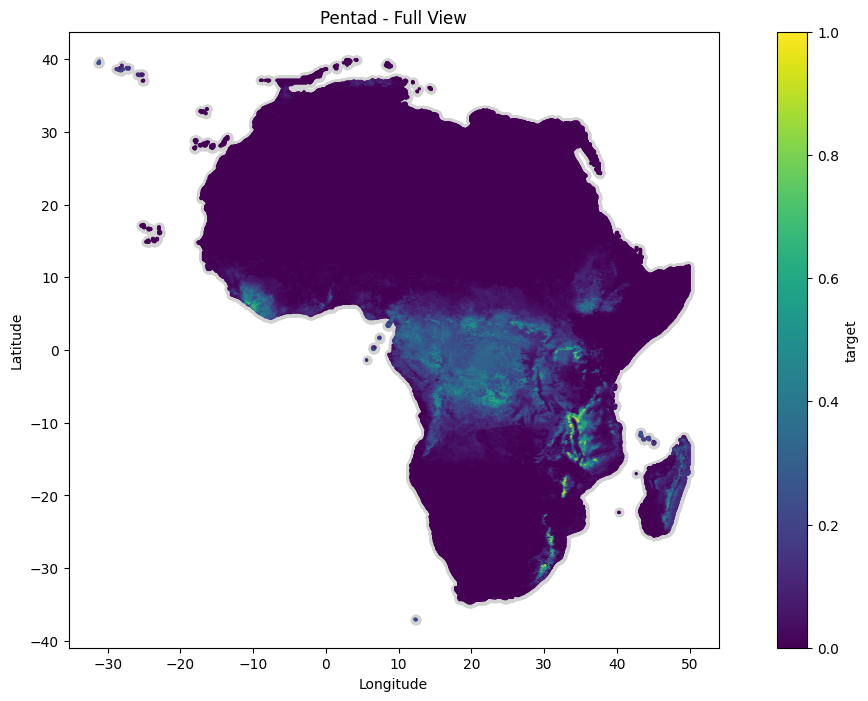

KeyboardInterrupt: ignored

In [ ]:
# create a new dataframe with rows where target = -1
to_predict_df = training_data_df[training_data_df['target'] == -1]

proba_predictions = clf.predict_proba(to_predict_df.drop(columns=drop_cols))
# Extract the probability of class 1
class_1_probabilities = proba_predictions[:, 1]

to_predict_df['target'] = class_1_probabilities
# to_predict_df['target'] = proba_predictions

known_df = pd.concat([positive_df, negative_df])
# known_df['target'] = np.where(known_df['target']==0, -1, np.where(known_df['target']==1, 2, known_df['target']))

combined_df = pd.concat([known_df, to_predict_df])

plot_map(combined_df, 'target', filename='blue_swallow_100pt_500pat', alongside=False)

combined_df.loc[combined_df['target'] < 0.7, 'target'] = 0
# colors = combined_df['target'].map({1:'lightgreen', 0:'lightcoral', 2:'green', -1: 'red'}).values

plot_map(combined_df, 'target', filename='blue_swallow_50pt_500pat', alongside=False)